<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/base_cnn/Acc_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APS360 Project: Speech Accent Classifier Project

**Members**: 
Catherine Glossop, Julia Chae, Mingshi Chi, Rocco Ruan 



## Set Up

In [ ]:
# package imports 

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display


In [ ]:
# mounting the Google Drive 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataloading utils  

# can load in data from image-conveted dataset 
def generate_data_image():
  data_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(128)])
  train_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/mfcc_processed/train', transform=data_transform)
  test_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/mfcc_processed/test', transform=data_transform)
  val_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/mfcc_processed/validation', transform=data_transform)

  return train_data, val_data, test_data

def visualize_image_data(dataset):
  batch = 27
  num_workers = 1

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

  # Visualize some sample data
  classes = ['english', 'mandarin', 'hindi', 'tagalog']

  # obtain one batch of training images
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display
  print(images.shape)
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])

# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  data = torchvision.datasets.DatasetFolder(root='/content/drive/My Drive/APS360 Group Project/data_mfcc_npy', loader=numpy_loader,extensions='.npy',transform=data_transform)
  return data

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'hindi', 'tagalog']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0].reshape(128,128))
    plt.colorbar()


In [ ]:
# train utils 

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        out = model(imgs) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

## Preparing & Visualizing Dataset

(27, 3, 128, 192)


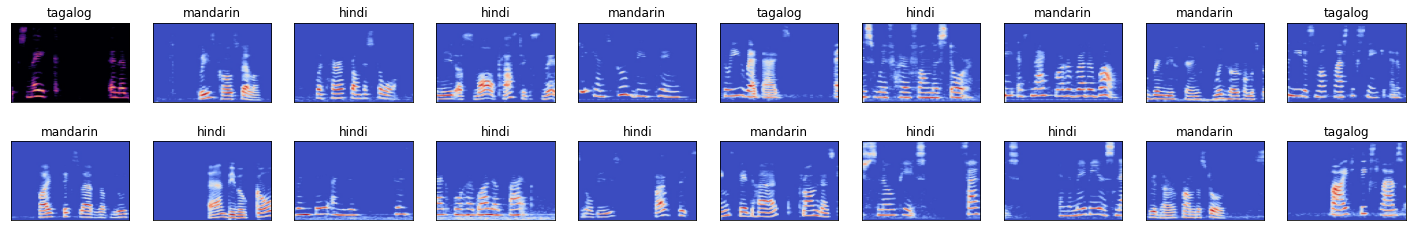

In [ ]:
train_data, val_data, test_data= generate_data_image()
visualize_image_data(train_data)

## Accent Classifier Architecture


## Training 

In [ ]:
def train_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    # Train a classifier on sign language images
    # Fixed PyTorch random seed for reproducible result
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    # The loss function will be Cross Entropy and Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            out = net(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = imgs.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        if (epoch>0 and (epoch+1)%10==0):
          model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
          torch.save(net.state_dict(), model_path)
    
    plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))
    

## Baseline Experimentation

In [ ]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_1.1'
          self.conv1 = nn.Conv2d(3, 5, 3) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(5, 10, 3) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(30*46*10, 560)
          self.fc2 = nn.Linear(560, 9)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 30*46*10)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.296078431372549 Val Accuracy:  0.2827586206896552 Progress:   2.00  % Time Elapsed:   9.75 s 
Epoch 0 Finished.  Time per Epoch:   9.75 s 
Epoch:  1 Train Accuracy:  0.3862745098039216 Val Accuracy:  0.2827586206896552 Progress:   4.00  % Time Elapsed:  19.63 s 
Epoch 1 Finished.  Time per Epoch:   9.82 s 
Epoch:  2 Train Accuracy:  0.33725490196078434 Val Accuracy:  0.23448275862068965 Progress:   6.00  % Time Elapsed:  29.49 s 
Epoch 2 Finished.  Time per Epoch:   9.83 s 
Epoch:  3 Train Accuracy:  0.30980392156862746 Val Accuracy:  0.2827586206896552 Progress:   8.00  % Time Elapsed:  39.31 s 
Epoch 3 Finished.  Time per Epoch:   9.83 s 
Epoch:  4 Train Accuracy:  0.34901960784313724 Val Accuracy:  0.2827586206896552 Progress:  10.00  % Time Elapsed:  49.17 s 
Epoch 4 Finished.  Time per Epoch:   9.83 s 
Epoch:  5 Train Accuracy:  0.3803921568627451 Val Accuracy:  0.23448275862068965 Progress:  12.00  % Time Elapsed:  59.01 s 
Epoch 5 Finished

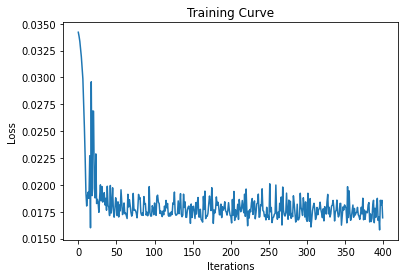

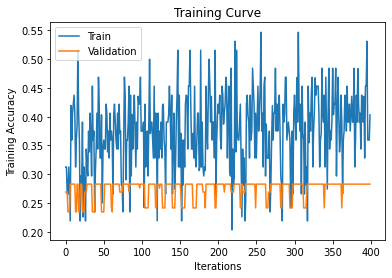

Finished Training
Total time:   494.29 s  Time per Epoch:   9.89 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 64
num_epochs = 50
learning_rate = 0.01
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

Changed input and output channel size in Conv2d layers to improve training. From 5 -> 10, the channels were drastically increased to 32 -> 64, to increase the number of parameters. 

In [ ]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_1.1'
          self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(30*46*64, 200)
          self.fc2 = nn.Linear(200, 9)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 30*46*64)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.3176470588235294 Val Accuracy:  0.2413793103448276 Progress:   2.00  % Time Elapsed:   9.84 s 
Epoch 0 Finished.  Time per Epoch:   9.84 s 
Epoch:  1 Train Accuracy:  0.36470588235294116 Val Accuracy:  0.2827586206896552 Progress:   4.00  % Time Elapsed:  20.16 s 
Epoch 1 Finished.  Time per Epoch:  10.08 s 
Epoch:  2 Train Accuracy:  0.3803921568627451 Val Accuracy:  0.2827586206896552 Progress:   6.00  % Time Elapsed:  30.79 s 
Epoch 2 Finished.  Time per Epoch:  10.27 s 
Epoch:  3 Train Accuracy:  0.38235294117647056 Val Accuracy:  0.23448275862068965 Progress:   8.00  % Time Elapsed:  41.29 s 
Epoch 3 Finished.  Time per Epoch:  10.32 s 
Epoch:  4 Train Accuracy:  0.3 Val Accuracy:  0.2827586206896552 Progress:  10.00  % Time Elapsed:  51.92 s 
Epoch 4 Finished.  Time per Epoch:  10.38 s 
Epoch:  5 Train Accuracy:  0.3862745098039216 Val Accuracy:  0.2827586206896552 Progress:  12.00  % Time Elapsed:  62.56 s 
Epoch 5 Finished.  Time per Epoc

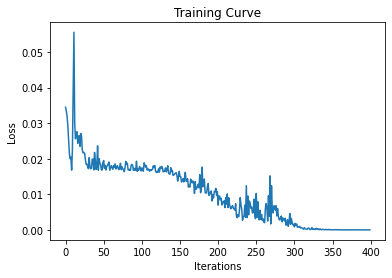

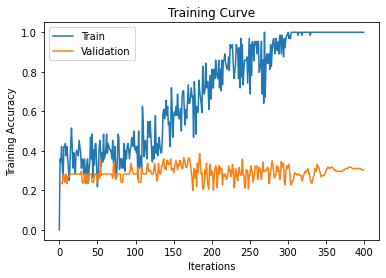

Finished Training
Total time:   668.94 s  Time per Epoch:  13.38 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 64
num_epochs = 50
learning_rate = 0.01
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

The above model is able to overfit to the data which is an improvement from model 1.0. This suggests that the model has the capacity to perform this task, and passes the sanity check. 

However, the model still performs very poorly as the validation accuracy remains very low. This seems to confirm one of our earlier suspicions that the training dataset size may be too small to teach the network enough information to be able to generalize well. 

To check if this situation can be improved, we will experiment with adding dropout next. 

In [ ]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_1.2'
          self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(30*46*64, 200)
          self.fc2 = nn.Linear(200, 9)
          self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 30*46*64)
          x = F.relu(self.fc1(x))
          x = self.dropout(self.fc2(x))
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.2784313725490196 Val Accuracy:  0.296551724137931 Progress:   2.00  % Time Elapsed:  13.47 s 
Epoch 0 Finished.  Time per Epoch:  13.47 s 
Epoch:  1 Train Accuracy:  0.30392156862745096 Val Accuracy:  0.2620689655172414 Progress:   4.00  % Time Elapsed:  27.40 s 
Epoch 1 Finished.  Time per Epoch:  13.70 s 
Epoch:  2 Train Accuracy:  0.3058823529411765 Val Accuracy:  0.296551724137931 Progress:   6.00  % Time Elapsed:  40.97 s 
Epoch 2 Finished.  Time per Epoch:  13.66 s 
Epoch:  3 Train Accuracy:  0.29215686274509806 Val Accuracy:  0.2896551724137931 Progress:   8.00  % Time Elapsed:  54.77 s 
Epoch 3 Finished.  Time per Epoch:  13.69 s 
Epoch:  4 Train Accuracy:  0.34901960784313724 Val Accuracy:  0.22758620689655173 Progress:  10.00  % Time Elapsed:  68.37 s 
Epoch 4 Finished.  Time per Epoch:  13.67 s 
Epoch:  5 Train Accuracy:  0.3509803921568627 Val Accuracy:  0.296551724137931 Progress:  12.00  % Time Elapsed:  81.98 s 
Epoch 5 Finished.  

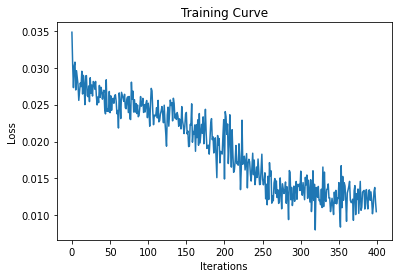

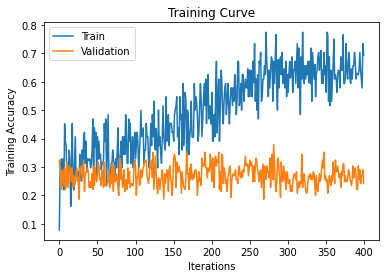

Finished Training
Total time:   681.30 s  Time per Epoch:  13.63 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 64
num_epochs = 50
learning_rate = 0.01
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)